In [5]:
import os, sys
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

In [6]:
adata1 = sc.read_h5ad(".\data\A1.h5ad")
adata2 = sc.read_h5ad(".\data\A2.h5ad")

In [17]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]

[<Axes: title={'center': 'adata2'}, xlabel='spatial1', ylabel='spatial2'>]

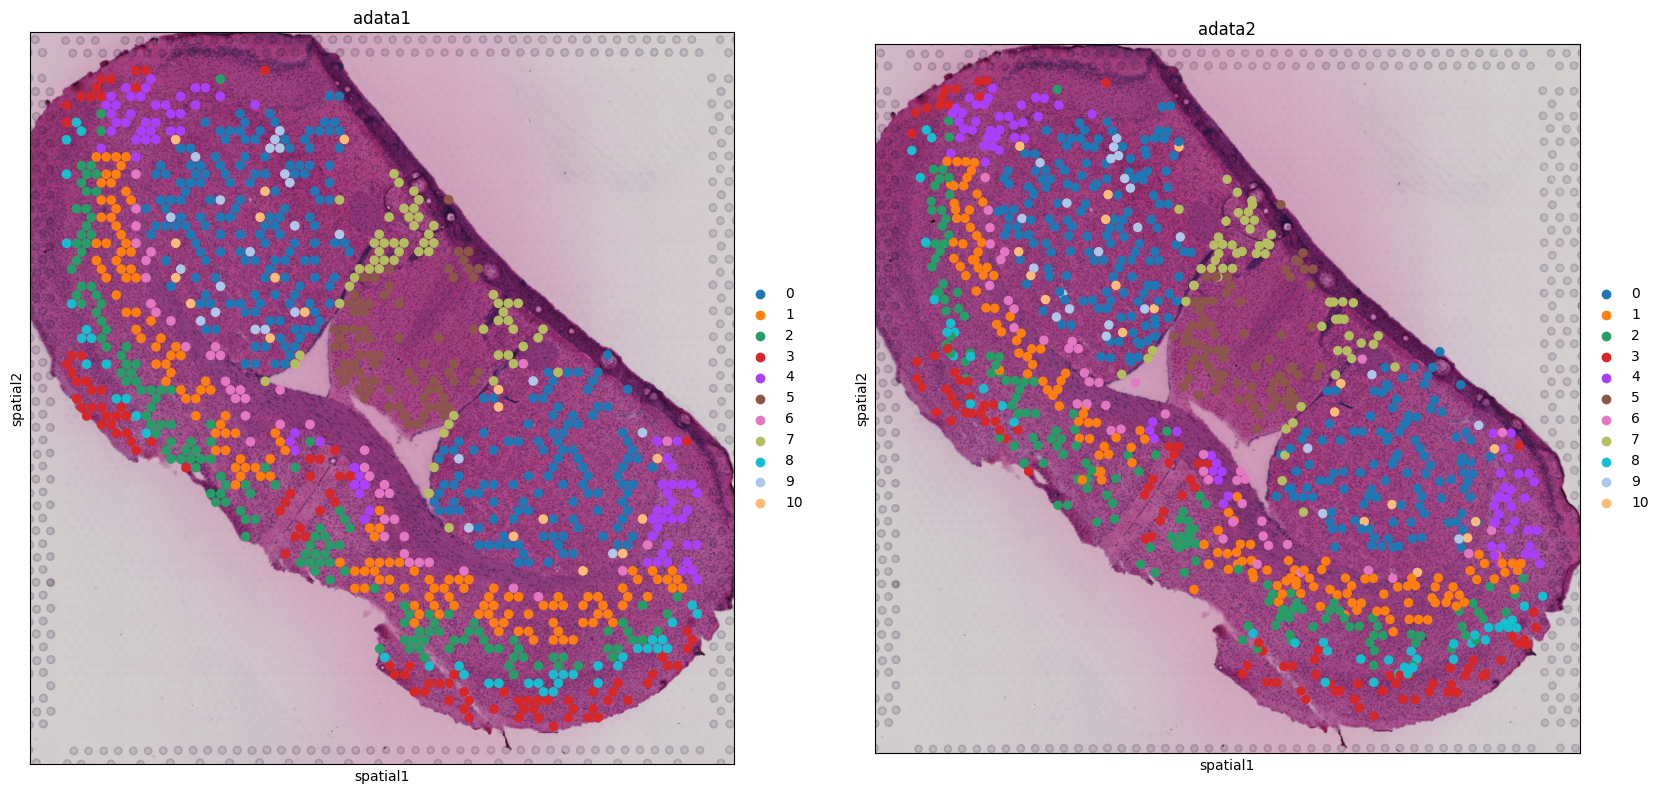

In [18]:
import matplotlib.pyplot as plt
# sc.pl.spatial(adata1, img_key = "hires", color="clusters", size=1.5, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray_plot.pdf")
# sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5, show=False)

# put the two images side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sc.pl.spatial(adata1, img_key = "hires", color="clusters", size=1.5, show=False, ax=axs[0], title="adata1")
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5, show=False, ax=axs[1], title="adata2")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_ctrl.pdf")

In [13]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [19]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})
    
def center_and_scale(data, feature_range=(0, 500)):
    """
    对数据进行中心缩放和范围缩放
    """
    # 中心缩放
    scaler_center = StandardScaler()
    data_centered = scaler_center.fit_transform(data)
    
    # 范围缩放
    scaler_range = MinMaxScaler(feature_range=feature_range)
    data_scaled = scaler_range.fit_transform(data_centered)
    
    return data_scaled
    
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-100, 100))
data1_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
#scaled_data = scaler.fit_transform(data3_spatial_results)
scaled_data = center_and_scale(data1_spatial_results)
data1_spatial_results = pd.DataFrame(scaled_data, columns=data1_spatial_results.columns)
print(data1_spatial_results.head)
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = center_and_scale(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data2_spatial_results.columns)

data2_spatial_results=pd.DataFrame(data2_spatial_results)
data1_spatial_results=pd.DataFrame(data1_spatial_results)

<bound method NDFrame.head of               0           1
0    125.934554   79.028266
1    287.544696  375.042334
2    236.252573  236.876384
3    480.211832  315.592028
4    413.262542  243.259086
..          ...         ...
995  354.209557  197.251531
996  196.784592  118.431679
997  334.827717  440.810212
998  137.785784  125.087925
999   86.669737  131.718119

[1000 rows x 2 columns]>


(1000, 2) (1000, 2)
(1000, 1000)
(1000, 2) (1000, 2)
(1000, 2) (1000, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     123.197625      81.407895           0                0             -1   
1     297.709924     364.947368           1                6             -1   
2     239.636344     230.500000           2                5             -1   
3     469.849979     320.368421           3                4             -1   
4     406.077714     238.802632           4                0             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       125.934554        79.028266             0                  0   
1       287.544696       375.042334             1                  6   
2       236.252573       236.876384             2                  5   
3       472.342616       315.605054           659                  4   
4       413.262542       243.259086             4                  0   

   matabolic.CCA.Z 

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\141906039.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\141906039.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


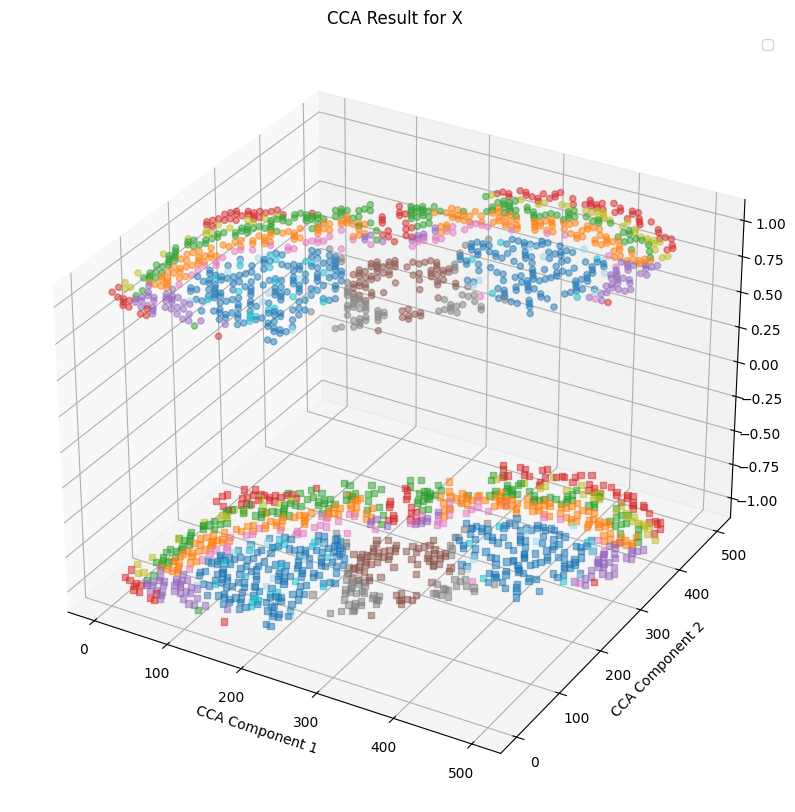

In [20]:
from scipy.spatial.distance import cdist
Y_c = data2_spatial_results
Z_c = data1_spatial_results
print(Z_c.shape, Y_c.shape)
distances = cdist(data1_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["metabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

In [21]:
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'cyan',
    12: 'blue',
    13: 'red',
    14: 'green',
    15: 'yellow'
}

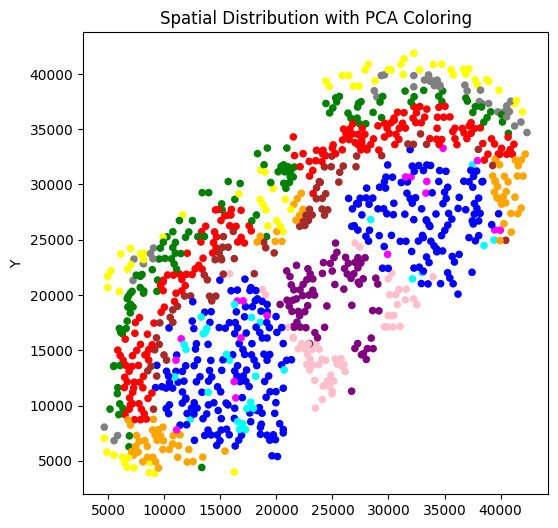

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.show()


In [24]:
same_values_mask_directmerge = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
same_values_count_fine = same_values_mask_directmerge.sum()
accruracy_directmerge = same_values_count_fine
accruracy_directmerge

761

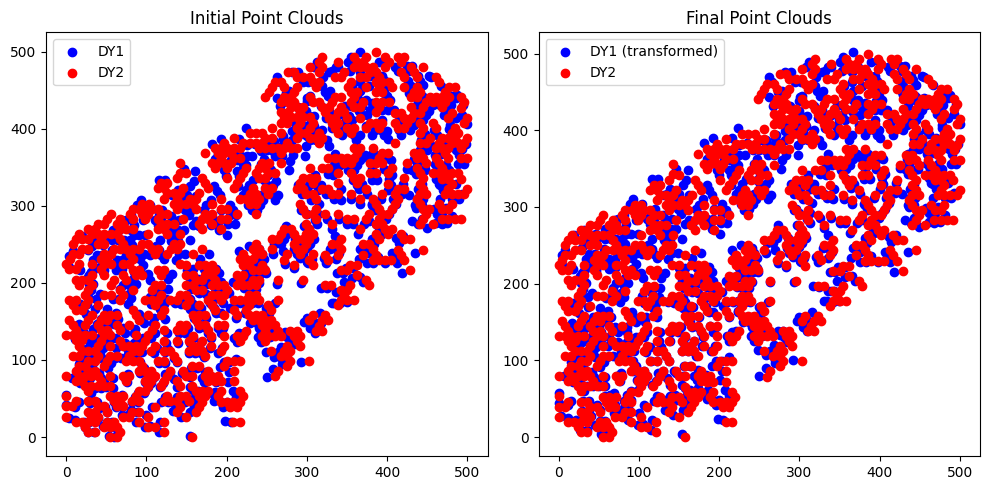

Final transformation matrix:
[[ 3.31112915e-15]
 [-1.05977449e-14]]


In [25]:
#####direct_ICP
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

DY1 = data2_spatial_results.T.to_numpy()  # Example DYGW1 features
DY2 = data1_spatial_results.T.to_numpy()  # Example DYGW2 features

transformation = np.eye(2)  # 初始变换矩阵为2x2的单位矩阵

# 设定迭代次数和收敛阈值
max_iterations = 500
tolerance = 1e-5

# 创建一个新的图形窗口
plt.figure(figsize=(10, 5))

# 绘制初始的DY1和DY2点云
plt.subplot(1, 2, 1)
plt.title('Initial Point Clouds')
plt.scatter(DY1[0], DY1[1], color='blue', label='DY1')
plt.scatter(DY2[0], DY2[1], color='red', label='DY2')
plt.legend()

iteration = 0
converged = False

while not converged and iteration < max_iterations:
    # Step 1: Find correspondences based on spatial proximity
    tree = cKDTree(DY2.T)
    distances, indices = tree.query(DY1.T)
    
    corresponding_target_points = DY2[:, indices]

    # Step 2: Optimize transformation using spatial and feature distances
    # Example: simple averaging transformation for illustration
    transformation = np.mean(corresponding_target_points - DY1, axis=1, keepdims=True)

    # Step 3: Apply transformation to DY1
    DY1_transformed = DY1 + transformation

    # Step 4: Update DY1 for the next iteration
    DY1 = DY1_transformed

    # Step 5: Check convergence
    if np.linalg.norm(transformation) < tolerance:
        converged = True

    iteration += 1

# 绘制最终的DY1和DY2点云
plt.subplot(1, 2, 2)
plt.title('Final Point Clouds')
plt.scatter(DY1[0], DY1[1], color='blue', label='DY1 (transformed)')
plt.scatter(DY2[0], DY2[1], color='red', label='DY2')
plt.legend()

plt.tight_layout()
plt.show()

print("Final transformation matrix:")
print(transformation)

(1000, 2) (1000, 2)
(1000, 1000)
(1000, 2) (1000, 2)
(1000, 2) (1000, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     123.273034      83.939536           0                0             -1   
1     297.785332     367.479009           1                6             -1   
2     239.711753     233.031641           2                5             -1   
3     469.925387     322.900062           3                4             -1   
4     406.153123     241.334272           4                0             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       125.934554        79.028266             0                  0   
1       287.544696       375.042334             1                  6   
2       236.252573       236.876384             2                  5   
3       476.283996       322.183144           526                  4   
4       413.262542       243.259086             4                  0   

   matabolic.CCA.Z 

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\4280202264.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\4280202264.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


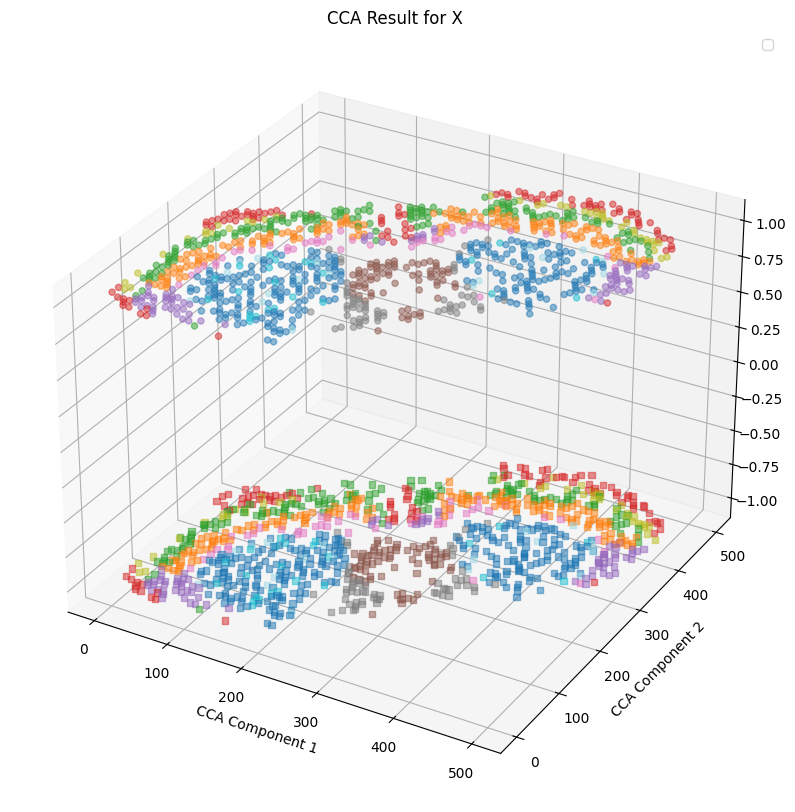

In [26]:
Y_c = pd.DataFrame(DY1).T
Z_c = pd.DataFrame(DY2).T
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices_ = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices_,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices_].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

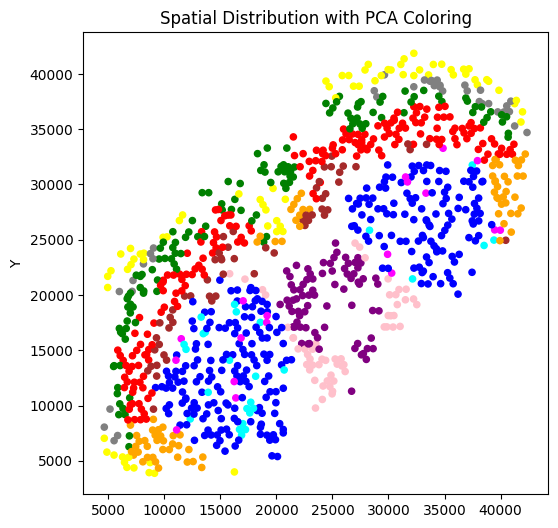

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
#plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\rat\\directalignment.pdf")
plt.show()


In [29]:
same_values_mask_directmerge = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
same_values_count_fine = same_values_mask_directmerge.sum()
accruracy_ICP = same_values_count_fine
accruracy_ICP

796

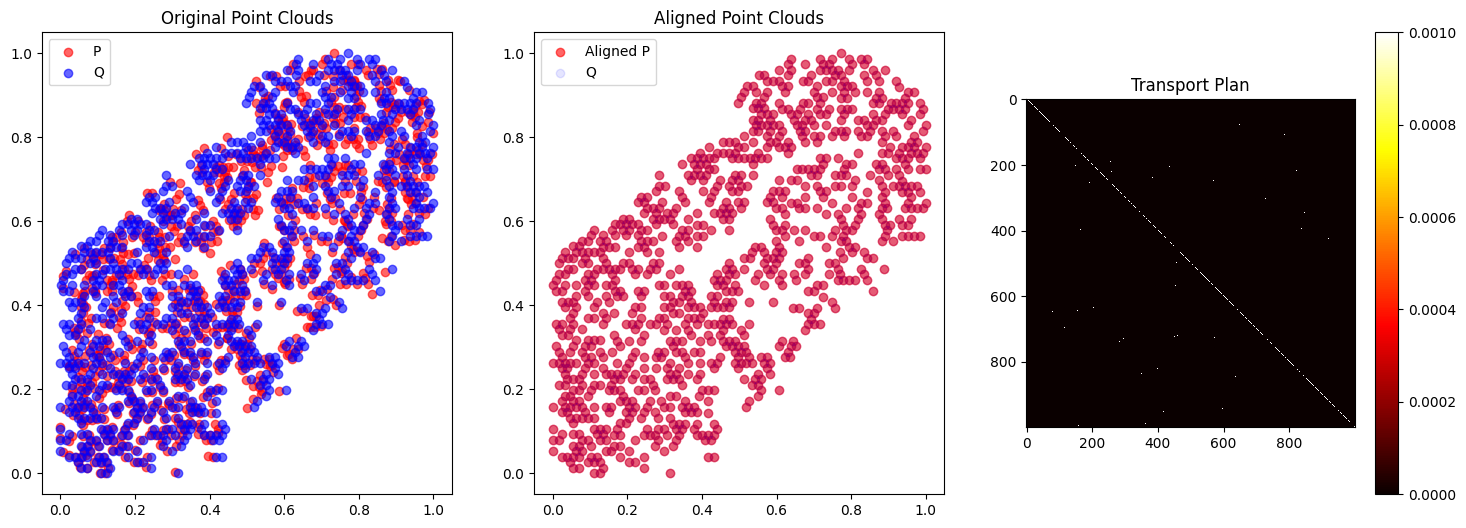

In [30]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# 假设 P 和 Q 是两个点云，形状分别为 (n, d) 和 (m, d)
P = data2_spatial_results.to_numpy()  # Example DYGW1 features
Q = data1_spatial_results.to_numpy()  # Example DYGW2 features

# 特征矩阵（这里假设特征与坐标相同）
F_P = P
F_Q = Q

# 数据标准化
scaler = StandardScaler()
P = scaler.fit_transform(P)
Q = scaler.fit_transform(Q)

# 数据归一化
scaler = MinMaxScaler()
P = scaler.fit_transform(P)
Q = scaler.fit_transform(Q)

# 计算几何距离矩阵
C_P = np.linalg.norm(P[:, None, :] - P[None, :, :], axis=2)
C_Q = np.linalg.norm(Q[:, None, :] - Q[None, :, :], axis=2)

# 计算特征距离矩阵
M = np.linalg.norm(F_P[:, None, :] - F_Q[None, :, :], axis=2)

# 初始化权重，均匀分布
a = np.ones((P.shape[0],)) / P.shape[0]
b = np.ones((Q.shape[0],)) / Q.shape[0]

# 设置平衡参数
alpha = 0.5

# 设置参数
params = {
    'max_iter': 2000,    # 增加最大迭代次数
    'tol_rel': 1e-7,     # 调整相对容差
    'tol_abs': 1e-9,     # 调整绝对容差
    'armijo': True       # 使用Armijo线搜索
}

# 计算FGW最优传输计划
pi, log = ot.gromov.fused_gromov_wasserstein(M,C_P, C_Q, a, b, alpha=alpha, log=True, **params)

# 对齐点云 P 到 Q
P_aligned = np.dot(pi, Q)
scaler = StandardScaler()
P_aligned = scaler.fit_transform(P_aligned)
scaler = MinMaxScaler()
P_aligned = scaler.fit_transform(P_aligned)


# 可视化
plt.figure(figsize=(18, 6))

# 原始点云
plt.subplot(1, 3, 1)
plt.scatter(P[:, 0], P[:, 1], color='red', label='P', alpha=0.6)
plt.scatter(Q[:, 0], Q[:, 1], color='blue', label='Q', alpha=0.6)
plt.title('Original Point Clouds')
plt.legend()

# 对齐后的点云
plt.subplot(1, 3, 2)
plt.scatter(P_aligned[:, 0], P_aligned[:, 1], color='red', label='Aligned P', alpha=0.6)
plt.scatter(Q[:, 0], Q[:, 1], color='blue', label='Q', alpha=0.1)
plt.title('Aligned Point Clouds')
plt.legend()

# 可视化传输计划
plt.subplot(1, 3, 3)
plt.imshow(pi, cmap='hot', interpolation='nearest')
plt.title('Transport Plan')
plt.colorbar()

plt.show()


(1000, 2) (1000, 2)
(1000, 1000)
(1000, 2) (1000, 2)
(1000, 2) (1000, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0       0.251869       0.158057           0                0             -1   
1       0.575089       0.750085           1                6             -1   
2       0.472505       0.473753           2                5             -1   
3       0.960424       0.631184           3                4             -1   
4       0.826525       0.486518           4                0             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0         0.251869         0.158057             0                  0   
1         0.575089         0.750085             1                  6   
2         0.472505         0.473753             2                  5   
3         0.960424         0.631184             3                  4   
4         0.826525         0.486518             4                  0   

   matabolic.CCA.Z 

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\2150073477.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\2150073477.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


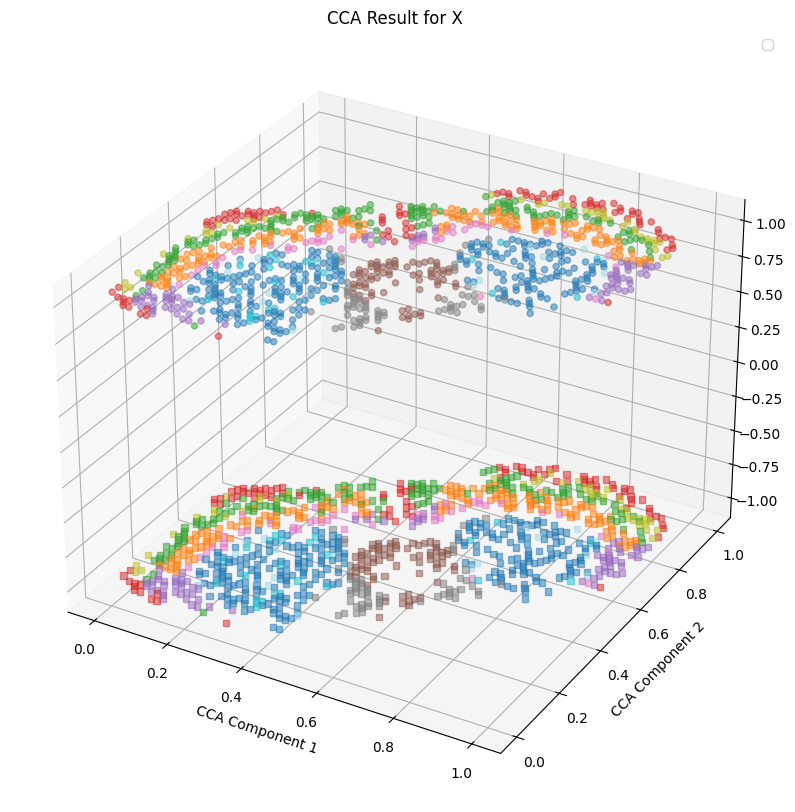

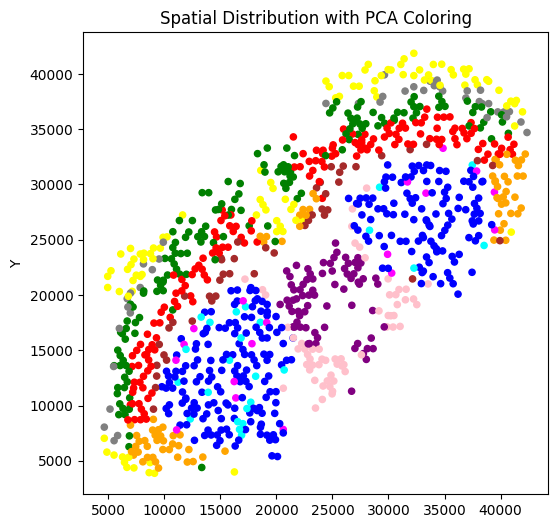

In [31]:
Y_c = pd.DataFrame(P_aligned)
Z_c = pd.DataFrame(Q)
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices_ = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices_,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices_].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
#plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\rat\\FPWalignment.pdf")
plt.show()
same_values_mask_directmerge = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
same_values_count_fine = same_values_mask_directmerge.sum()
accruracy_FPWmerge = same_values_count_fine

In [32]:
accruracy_FPWmerge

883

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\972873380.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


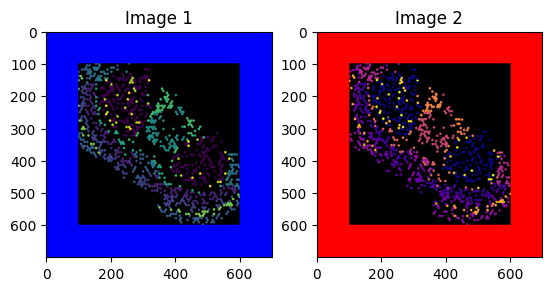

Transformation Matrix:
 [[ 9.86000000e-01 -2.04024145e-03  2.65010463e+00]
 [-8.22524035e-17  9.97987928e-01  2.05231388e-01]]


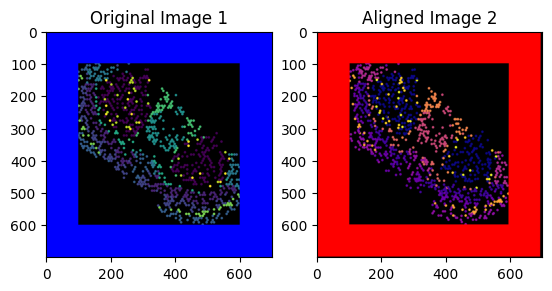

              0           1
0    122.352847   81.248120
1    293.843484  364.217092
2    236.857240  230.040241
3    463.664531  319.727841
4    400.951492  238.326168
..          ...         ...
995  342.344091  200.428889
996  192.532037  115.573652
997  342.177502  428.928730
998  137.753609  122.283808
999   84.362393  134.364715

[1000 rows x 2 columns]
              0           1
0    122.352847   81.248120
1    293.843484  364.217092
2    236.857240  230.040241
3    463.664531  319.727841
4    400.951492  238.326168
..          ...         ...
995  342.344091  200.428889
996  192.532037  115.573652
997  342.177502  428.928730
998  137.753609  122.283808
999   84.362393  134.364715

[1000 rows x 2 columns]


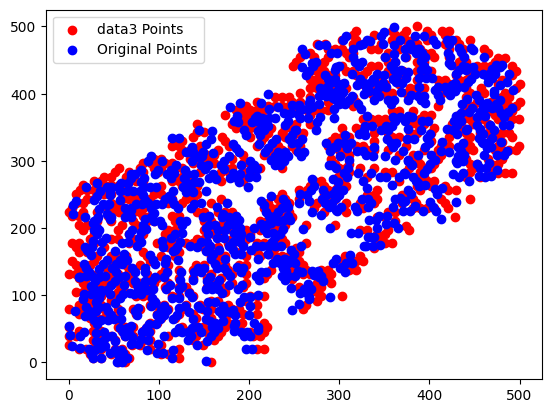

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_image_from_data(data, width=500, height=500, dot_size=5, border_size=50, dot_colors=None, border_color=(0, 0, 0), colormap='viridis'):
    """
    Create an image from 2D data points with specified dot size, border size, and colors.

    Parameters:
    - data: 2D numpy array where data[0] contains x coordinates and data[1] contains y coordinates
    - width: Width of the image
    - height: Height of the image
    - dot_size: Size of the dots
    - border_size: Size of the border around the image
    - dot_colors: List of scalar values for each dot, which will be mapped to colors using a colormap
    - border_color: Color of the border (BGR format)
    - colormap: Colormap to use for mapping scalar values to colors
    
    Returns:
    - bordered_image: Image with data points and border
    """
    # Initialize an empty image with three channels for color
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # Normalize data points to image dimensions
    x_norm = np.interp(data[0], (data[0].min(), data[0].max()), (0, width-1))
    y_norm = np.interp(data[1], (data[1].min(), data[1].max()), (0, height-1))

    # Normalize dot_colors to [0, 1] range
    if dot_colors is not None:
        norm = plt.Normalize(vmin=min(dot_colors), vmax=max(dot_colors))
        cmap = cm.get_cmap(colormap)
        mapped_colors = cmap(norm(dot_colors))

    # Draw circles at normalized positions
    for i, (x, y) in enumerate(zip(x_norm, y_norm)):
        if dot_colors is not None:
            color = (mapped_colors[i][:3] * 255).astype(int)  # Convert to BGR format
            color = tuple(map(int, color[::-1]))  # Convert from RGB to BGR
        else:
            color = (255, 255, 255)  # Default white color
        cv2.circle(image, (int(x), int(y)), dot_size, color, -1)  # -1 means filled circle

    # Add border
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                        cv2.BORDER_CONSTANT, value=border_color)

    return bordered_image

# Simulated scalar values
dot_colors_1 = data1_leiden_str.astype(int)
dot_colors_2 = data2_leiden_str.astype(int)

# Create images
border_size = 100
img1 = create_image_from_data(data1_spatial_results, width=500, height=500, dot_size=4, border_size=border_size, dot_colors=dot_colors_1, border_color=(255, 0, 0), colormap='viridis')
img2 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=border_size, dot_colors=dot_colors_2, border_color=(0, 0, 255), colormap='plasma')

# Display images using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')

plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lists to store points
points_image1 = []
points_image2 = []

def click_event_image1(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image1.append((x, y))
        cv2.circle(img1_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 1', img1_display)

def click_event_image2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image2.append((x, y))
        cv2.circle(img2_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 2', img2_display)

def compute_affine_transform(points_image1, points_image2):
    pts1 = np.float32(points_image1)
    pts2 = np.float32(points_image2)
    M = cv2.getAffineTransform(pts2[:3], pts1[:3])  # Use the first 3 points for affine transform
    return M

def warp_image(image, M, output_shape):
    warped_image = cv2.warpAffine(image, M, output_shape)
    return warped_image

# Load images
img1_display = img1.copy()
img2_display = img2.copy()

# Display images and set mouse callbacks
cv2.imshow('Image 1', img1_display)
cv2.imshow('Image 2', img2_display)
cv2.setMouseCallback('Image 1', click_event_image1)
cv2.setMouseCallback('Image 2', click_event_image2)

# Wait until 6 points are selected (3 from each image)
while len(points_image1) < 3 or len(points_image2) < 3:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Compute the transformation matrix
M = compute_affine_transform(points_image1, points_image2)
print("Transformation Matrix:\n", M)

# Apply the transformation to the second image
rows, cols = img1.shape[:2]
aligned_image = warp_image(img2, M, (cols, rows))

# Display the original and aligned images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image 2')
plt.show()

M_homogeneous = np.vstack([M, [0, 0, 1]])

# Convert DataFrame to homogeneous coordinates
coordinates_data3 = data1_spatial_results  # Add a column of 1s
coordinates_data2 = data2_spatial_results  # Add a column of 1s

def apply_affine_transform_2d(coordinates, transformation_matrix):
    """
    对二维坐标应用仿射变换
    """
    # 添加齐次坐标
    homogeneous_coordinates = np.hstack([coordinates, np.ones((coordinates.shape[0], 1))])
    
    # 应用仿射变换
    transformed_coordinates = np.dot(homogeneous_coordinates, transformation_matrix.T)
    
    return transformed_coordinates[:, :2]

transformed_coordinates_data2 = apply_affine_transform_2d(coordinates_data2+border_size, M_homogeneous)
transformed_coordinates_data2 = pd.DataFrame(transformed_coordinates_data2-border_size)
# Apply the transformation matrix
#transformed_coordinates_data3 = coordinates_data3.dot(M_homogeneous.T)
#transformed_coordinates_data2 = coordinates_data2.dot(M)
# Update the DataFrame with the transformed coordinates
#print(transformed_coordinates_data2)
#print(data3_spatial_results)
#plt.title('Original Points')
plt.scatter(data1_spatial_results[0], data1_spatial_results[1], color='red', label='data3 Points')
plt.scatter(transformed_coordinates_data2[0], transformed_coordinates_data2[1], color='blue', label='Original Points')


plt.legend()

print(transformed_coordinates_data2)
data2_spatial_results = transformed_coordinates_data2.iloc[:,0:2]
print(data2_spatial_results)

(1000, 2) (1000, 2)
(1000, 1000)
(1000, 2) (1000, 2)
(1000, 2) (1000, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     122.352847      81.248120           0                0             -1   
1     293.843484     364.217092           1                6             -1   
2     236.857240     230.040241           2                5             -1   
3     463.664531     319.727841           3                4             -1   
4     400.951492     238.326168           4                0             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       125.934554        79.028266             0                  0   
1       287.544696       375.042334             1                  6   
2       232.311193       230.298294           921                  5   
3       472.342616       315.605054           659                  4   
4       397.510565       230.115931            76                  0   

   matabolic.CCA.Z 

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\141906039.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\141906039.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


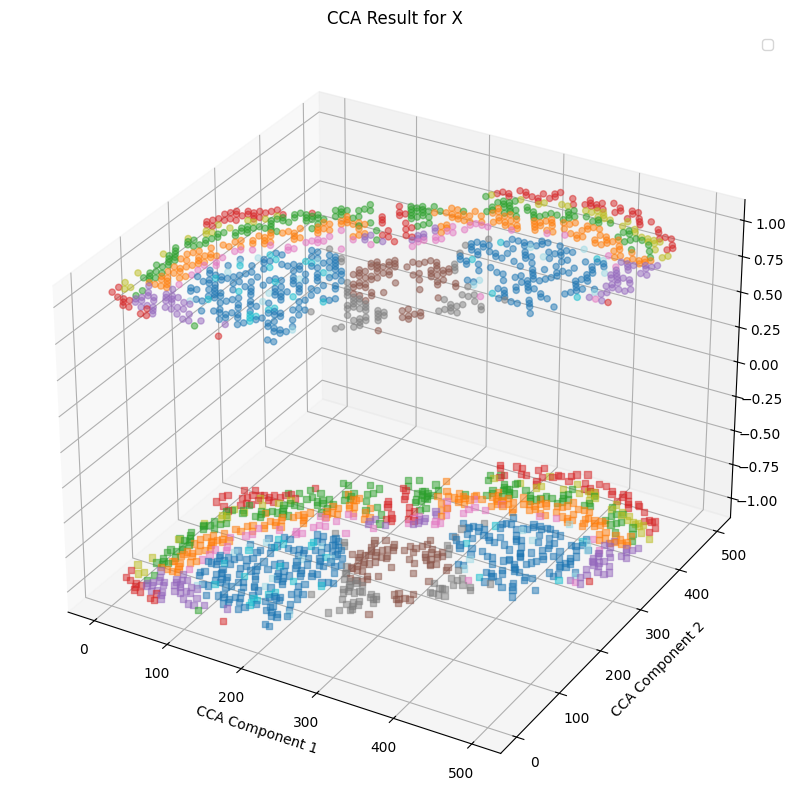

In [35]:
Y_c = data2_spatial_results
Z_c = data1_spatial_results
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(data1_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

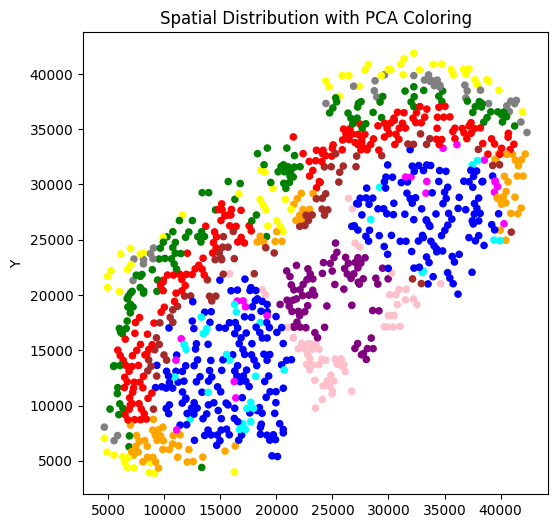

In [36]:
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
#plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\rat\\grossalignment.pdf")
plt.show()


In [37]:
same_values_mask_directmerge = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
same_values_count_fine = same_values_mask_directmerge.sum()
Accruracy_grossalignment = same_values_count_fine
Accruracy_grossalignment

745

In [38]:
X_c=pd.DataFrame(data1_spatial_results)
Y_c=pd.DataFrame(data2_spatial_results)
Z_c=pd.DataFrame(data1_spatial_results)

In [39]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})
    new_df = pd.merge(new_df, df[['spatial_ID', "spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')
    return new_df

def perform_transformations(DF2, DF1, Y_c, Z_c, data2_leiden_str, data1_leiden_str):
    transform_matrix = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])
    max_runs = 100
    run_count = 0
    while run_count < max_runs:
        run_count += 1
        distances = cdist(DF1, DF2, metric='euclidean')
        dist_df = pd.DataFrame(distances)
        
        row_indices, col_indices = np.where(distances < dist_min)
        
        Y_C_ = Y_c.iloc[col_indices, :]
        Y_C_['spatial_ID'] = Y_C_.index
        Y_C_ = Y_C_.reset_index()
        Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
        Y_C_["spatial.CCA.Z"] = -1
        Y_C_ = Y_C_.drop(columns=['index'])
        Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1: "spatial.CCA.Y"})
        
        Z_C_ = Z_c.iloc[row_indices, :]
        Z_C_['matabolic_ID'] = Z_C_.index
        Z_C_ = Z_C_.reset_index()
        Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
        Z_C_ = Z_C_.drop(columns=['index'])
        Z_C_["matabolic.CCA.Z"] = 1
        Z_C_ = Z_C_.rename(columns={0: "metabolic.CCA.X", 1: "metabolic.CCA.Y"})
        
        pairs = pd.concat([Y_C_, Z_C_], axis=1)
        pairs["distance"] = dist_df.iloc[row_indices, col_indices].values.diagonal()
        
        data = pairs
        df = pd.DataFrame(data)
        filtered_spatial_ids = df["spatial_ID"]
        dist_df = pd.DataFrame(distances)
        dist_df = dist_df.iloc[:,DF2.drop(filtered_spatial_ids.tolist()).index.to_numpy()]
        min_row_indices = dist_df.idxmin()
        print(f"min_row_indices",min_row_indices.shape)
        df2 = DF2.iloc[DF2.drop(filtered_spatial_ids.tolist()).index.to_numpy(),:].rename(columns = {
            0:"x",
            1:"y",
        })
        df3 =DF1.iloc[min_row_indices,:].rename(columns = {
            0:"x",
            1:"y",
        })


        def loss_function(params, df2, df3):
            tx, ty, theta = params
            translation_matrix = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
            transform_matrix = translation_matrix.dot(rotation_matrix)
            ones = np.ones((df2.shape[0], 1))
            df2_homogeneous = np.hstack([df2, ones])
            df2_transformed = df2_homogeneous.dot(transform_matrix.T)
            total_distance = 0
            for point, point1 in zip(df2_transformed[:, :2], df2):
                distances = np.linalg.norm(df3 - point, axis=1)
                distances2 = np.linalg.norm(point - point1)
                total_distance += np.sum(distances) + distances2*0
            return total_distance

        initial_params = [0, 0, 0]
        result = minimize(loss_function, initial_params, args=(df2.values, df3.values), method='L-BFGS-B')

        optimal_params = result.x
        tx_opt, ty_opt, theta_opt = optimal_params
        translation_matrix_opt = np.array([[1, 0, tx_opt], [0, 1, ty_opt], [0, 0, 1]])
        rotation_matrix_opt = np.array([[np.cos(theta_opt), -np.sin(theta_opt), 0], [np.sin(theta_opt), np.cos(theta_opt), 0], [0, 0, 1]])
        transform_matrix_opt = translation_matrix_opt.dot(rotation_matrix_opt)

        print("Optimal Translation and Rotation Parameters:")
        print("Translation: (", tx_opt, ",", ty_opt, ")")
        print("Rotation (radians):", theta_opt)
        print("Transform Matrix:\n", transform_matrix_opt)

        ones = np.ones((df2.shape[0], 1))
        df2_homogeneous = np.hstack([df2.values, ones])
        df2_transformed = df2_homogeneous.dot(transform_matrix_opt.T)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(df2['x'], df2['y'], label='df2 (original)', alpha=0.6)
        plt.scatter(df3['x'], df3['y'], label='df3', alpha=0.6)
        plt.title('Original Data')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(df2_transformed[:, 0], df2_transformed[:, 1], label='df2 (transformed)', alpha=0.6)
        plt.scatter(df3['x'], df3['y'], label='df3', alpha=0.6)
        plt.title('Transformed Data')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

        plt.tight_layout()
        plt.show()

        ones = np.ones((DF2.shape[0], 1))
        df2_homogeneous = np.hstack([DF2.values, ones])
        DF2 = df2_homogeneous.dot(transform_matrix_opt.T)
        DF2 = pd.DataFrame(DF2)
        DF2 = DF2.iloc[:, 0:2]

        if np.allclose(transform_matrix_opt, np.eye(3), atol=1e-3):
            break

    return DF2

# 调用函数并获取结果



C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


min_row_indices (977,)
Optimal Translation and Rotation Parameters:
Translation: ( 2.813783735671349e-06 , 3.3565757201578397e-06 )
Rotation (radians): -2.022056116920364e-05
Transform Matrix:
 [[ 1.00000000e+00  2.02205612e-05  2.81378374e-06]
 [-2.02205612e-05  1.00000000e+00  3.35657572e-06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


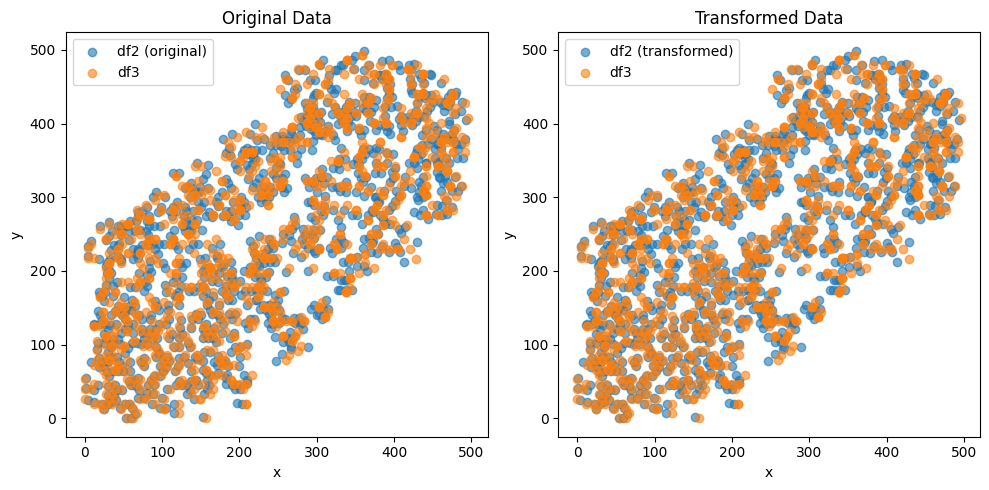

              0           1
0    122.354493   81.245650
1    293.850852  364.211154
2    236.861895  230.035455
3    463.670998  319.718468
4    400.956313  238.318063
..          ...         ...
995  342.348147  200.421970
996  192.534377  115.569763
997  342.186178  428.921815
998  137.756084  122.281026
999   84.365113  134.363012

[1000 rows x 2 columns]


In [40]:
dist_min = 1  # min euclidean distance
data2_spatial_results = perform_transformations(data2_spatial_results, data1_spatial_results, Y_c, Z_c, data2_leiden_str, data1_leiden_str)
print(data2_spatial_results)

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


min_row_indices (908,)
Optimal Translation and Rotation Parameters:
Translation: ( 3.0601463937757566e-06 , 3.461131093649821e-06 )
Rotation (radians): -2.2244098614066534e-05
Transform Matrix:
 [[ 1.00000000e+00  2.22440986e-05  3.06014639e-06]
 [-2.22440986e-05  1.00000000e+00  3.46113109e-06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


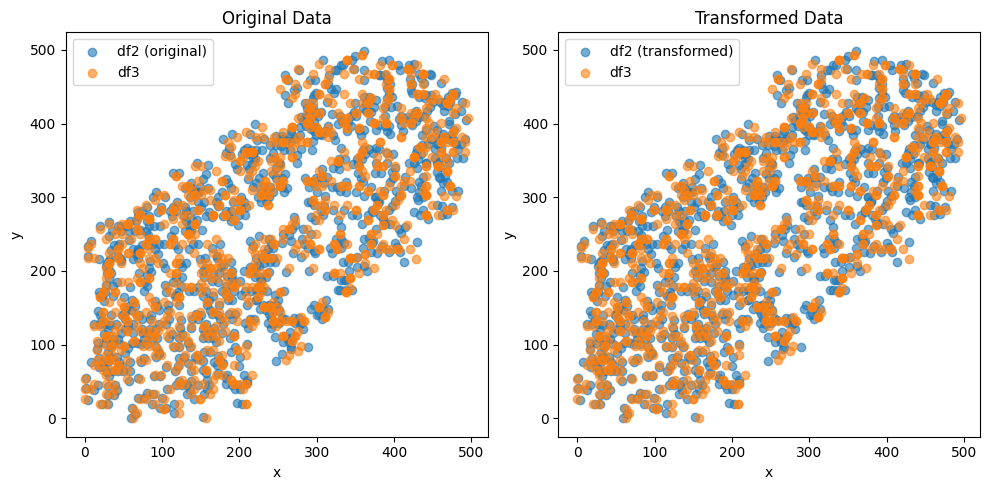

              0           1
0    122.356303   81.242931
1    293.858956  364.204621
2    236.867015  230.030190
3    463.678113  319.708158
4    400.961618  238.309148
..          ...         ...
995  342.352608  200.414358
996  192.536951  115.565483
997  342.195722  428.914206
998  137.758807  122.277965
999   84.368105  134.361139

[1000 rows x 2 columns]


In [41]:
dist_min = 2  # min euclidean distance
data2_spatial_results = perform_transformations(data2_spatial_results, data1_spatial_results, Y_c, Z_c, data2_leiden_str, data1_leiden_str)
print(data2_spatial_results)

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


min_row_indices (784,)
Optimal Translation and Rotation Parameters:
Translation: ( 6.519894758056169e-06 , 7.150851467067188e-06 )
Rotation (radians): -6.190530603885674e-05
Transform Matrix:
 [[ 9.99999998e-01  6.19053060e-05  6.51989476e-06]
 [-6.19053060e-05  9.99999998e-01  7.15085147e-06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


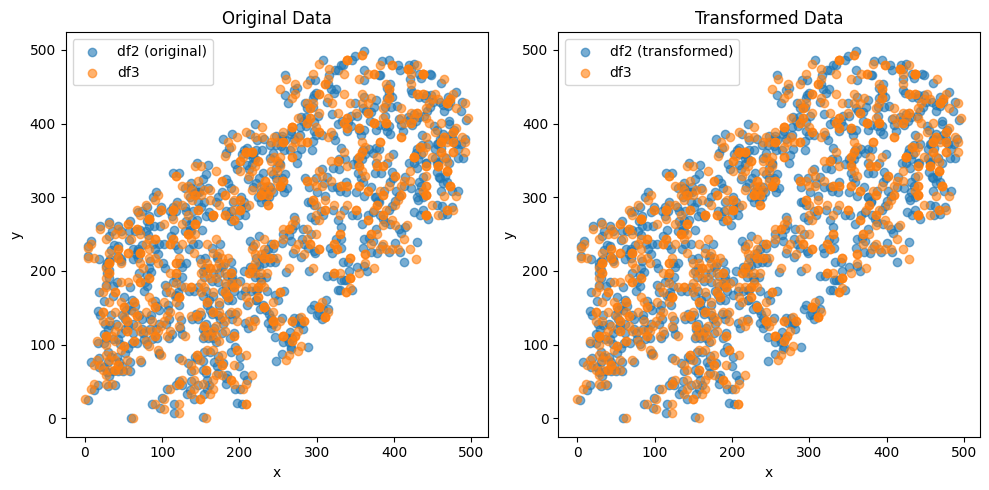

              0           1
0    122.361339   81.235364
1    293.881509  364.186436
2    236.881261  230.015533
3    463.697910  319.679460
4    400.976376  238.284333
..          ...         ...
995  342.365020  200.393172
996  192.544111  115.553571
997  342.222280  428.893029
998  137.766383  122.269444
999   84.376429  134.355923

[1000 rows x 2 columns]


In [42]:
dist_min = 3  # min euclidean distance
data2_spatial_results = perform_transformations(data2_spatial_results, data1_spatial_results, Y_c, Z_c, data2_leiden_str, data1_leiden_str)
print(data2_spatial_results)

min_row_indices (445,)
Optimal Translation and Rotation Parameters:
Translation: ( 9.913797836656362e-06 , 1.054746555132861e-05 )
Rotation (radians): 8.142044271437992e-05
Transform Matrix:
 [[ 9.99999997e-01 -8.14204426e-05  9.91379784e-06]
 [ 8.14204426e-05  9.99999997e-01  1.05474656e-05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\1740125892.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


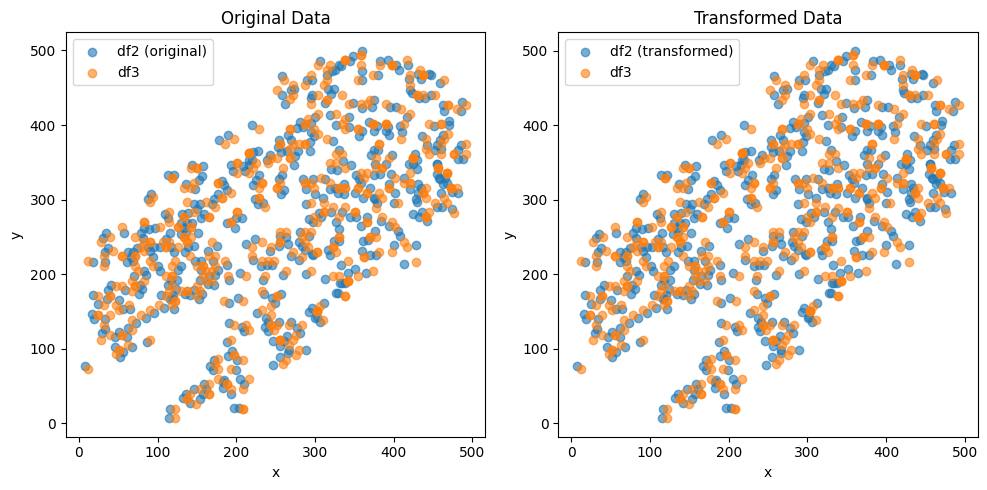

              0           1
0    122.185621   81.499779
1    293.093859  364.820890
2    236.383723  230.527108
3    463.006056  320.681036
4    400.460584  239.150541
..          ...         ...
995  341.931258  201.132794
996  192.294059  115.969590
997  341.294671  429.631809
998  137.501944  122.567058
999   84.085992  134.538119

[1000 rows x 2 columns]


In [54]:
dist_min = 5  # min euclidean distance
data2_spatial_results = perform_transformations(data2_spatial_results, data1_spatial_results, Y_c, Z_c, data2_leiden_str, data1_leiden_str)
print(data2_spatial_results)

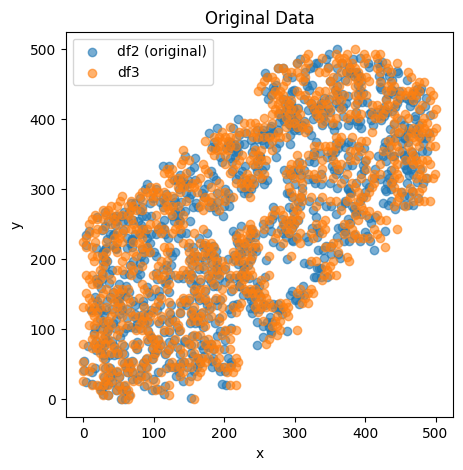

In [55]:
plt.figure(figsize=(5, 5))

plt.scatter(data2_spatial_results[0], data2_spatial_results[1], label='df2 (original)', alpha=0.6)
plt.scatter(data1_spatial_results[0], data1_spatial_results[1], label='df3', alpha=0.6)
plt.title('Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()



(1000, 2) (1000, 2)
(1000, 1000)
(1000, 2) (1000, 2)
(1000, 2) (1000, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     122.185621      81.499779           0                0             -1   
1     293.093859     364.820890           1                6             -1   
2     236.383723     230.527108           2                5             -1   
3     463.006056     320.681036           3                4             -1   
4     400.460584     239.150541           4                0             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       125.934554        79.028266             0                  0   
1       287.544696       375.042334             1                  6   
2       232.311193       230.298294           921                  5   
3       472.342616       315.605054           659                  4   
4       397.510565       230.115931            76                  0   

   matabolic.CCA.Z 

C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\2916384264.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
C:\Users\xiaoyuz\AppData\Local\Temp\ipykernel_13584\2916384264.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


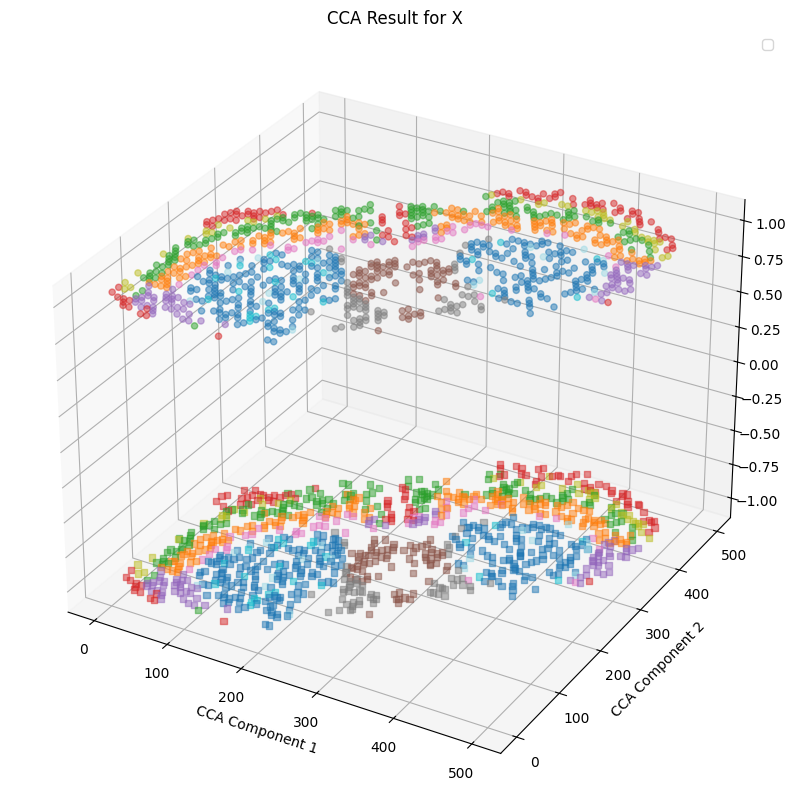

In [56]:
Y_c = data2_spatial_results
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(data1_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()


In [57]:
same_values_mask_fine = pairs['spatial_cluster'] == pairs['matabolic_cluster']

# 计算相同值的个数
same_values_count_fine = same_values_mask_fine.sum()
same_values_count_fine

750

In [146]:
#pairs.to_csv("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\no_anchorpair_run2.csv", index=False)

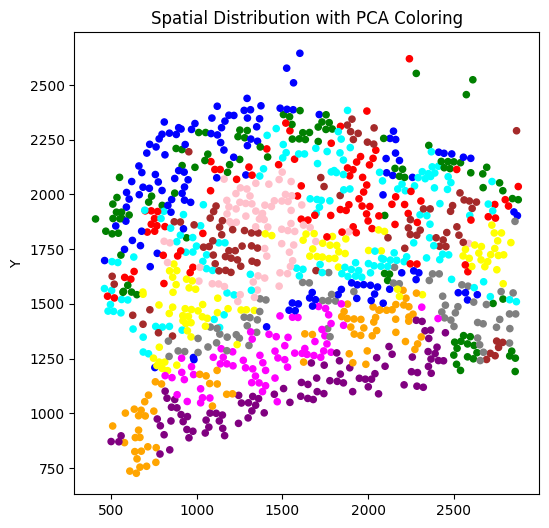

In [147]:
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
#plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\rat\\furtheralignment.pdf")
plt.show()


In [148]:
same_values_mask_directmerge = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
same_values_count_fine = same_values_mask_directmerge.sum()
Accruracy_furtheralignment = same_values_count_fine

In [149]:
dist_min = 2 ## min euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(data1_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
row_indices, col_indices = np.where(distances <dist_min)
unique_row_indices = np.unique(row_indices)
unique_col_indices = np.unique(col_indices)
#############plot
####Z_C is metablic and is at 1
Y_C_=Y_c.iloc[col_indices,]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_=Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_=Y_C_.drop(columns=['index'])
Y_C_=Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})

Z_C_=Z_c.iloc[row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})

pairs = pd.concat([Y_C_,Z_C_],axis=1)
pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  
print(pairs.head())


def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    # 保存每个 X1 中值对应的 X2 中值的列表
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()

    # 计算每个 X1 中值的辛普森指数
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)

    # 保存每个 X1 中值对应的 X2 中出现频率最高的值
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))

    # 生成新的 DataFrame
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})

    # 合并 X3 列
    new_df = pd.merge(new_df, df[['spatial_ID',"spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')

    return new_df

# 示例输入数据
data = pairs
df = pd.DataFrame(data)

# 调用主函数
result_df = main(df)
result_df

   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0     217.273565     463.886342         146                0             -1   
1      33.312727     279.761928         984                0             -1   
2     303.718064     292.945673         867                3             -1   
3     271.537501     293.241649         708                3             -1   
4     344.783481     285.023975         733               11             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0       218.369830       462.586852            25                  2   
1        31.630170       279.262427            52                  0   
2       302.716951       292.891502            59                 11   
3       271.289538       292.357028           143                  3   
4       345.904298       284.607162           183                  2   

   matabolic.CCA.Z  distance  
0                1  1.700138  
1                1  1.755135  

C:\Users\28123\AppData\Local\Temp\ipykernel_16672\237650377.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\28123\AppData\Local\Temp\ipykernel_16672\237650377.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0            9                            3            0.0                7
1           26                            1            0.0               11
2           28                            3            0.0                8
3           59                           11            0.0               11
4           92                           12            0.0               11
5          101                            3            0.0                1
6          104                           12            0.0               10
7          105                            7            0.0                7
8          121                            3            0.0                1
9          127                            3            0.0                3
10         146                            2            0.0                0
11         158                           12            0.0                8
12         159                           11            0.0               11
13         161                            3            0.0                3
14         162                           11            0.0                1
15         175                           11            0.0                3
16         180                            4            0.0               12
17         207                            4            0.0                4
18         220                           11            0.0                3
19         249                            0            0.0                0
20         313                            8            0.0                8
21         359                            0            0.0                0
22         430                            5            0.0               10
23         433                           11            0.0                1
24         443                           12            0.0                3
25         444                           11            0.0                1
26         455                            2            0.0                0
27         465                           11            0.0                6
28         487                            2            0.0                0
29         516                            8            0.0                8
30         536                            8            0.0               11
31         563                            9            0.0                9
32         567                            3            0.0                1
33         582                            3            0.0                7
34         594                            5            0.0               10
35         663                           11            0.0                6
36         665                            3            0.0                3
37         703                            2            0.0                9
38         705                            3            0.0                3
39         708                            3            0.0                3
40         711                           11            0.0                1
41         715                            0            0.0                0
42         724                           10            0.0               12
43         733                            2            0.0               11
44         758                            8            0.0               11
45         774                           11            0.0                3
46         781                            4            0.0                4
47         795                           10            0.0                3
48         828                            3            0.0                3
49         852                            2            0.0                0
50         854                           12            0.0               11
51         867                           11         

<bound method NDFrame.head of     spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0            9                            3            0.0                7
1           26                            1            0.0               11
2           28                            3            0.0                8
3           59                           11            0.0               11
4           92                           12            0.0               11
5          101                            3            0.0                1
6          104                           12            0.0               10
7          105                            7            0.0                7
8          121                            3            0.0                1
9          127                            3            0.0                3
10         146                            2            0.0                0
11         158                           12            0.0

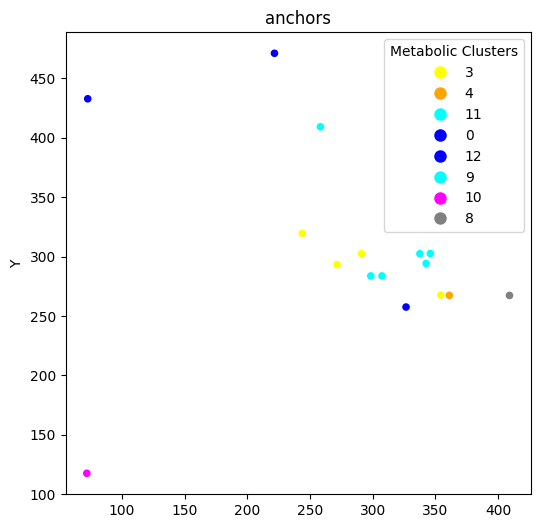

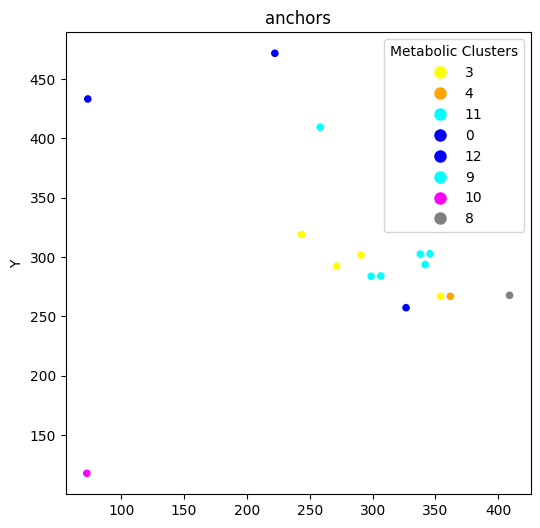

In [150]:
###### find transcript-metaboic pairs anchors by filtering: 
######1/simpson index less than 0.2 2/Most_freq_metabolic_cluster==matabolic_cluster
print(result_df.head)
#print(pairs.head)
merged_df = pd.merge(result_df, pairs, on='spatial_ID', how='inner')
merged_df = pd.DataFrame(merged_df)
print(merged_df)
merged_df = merged_df[(merged_df['Simpson_Index'] < 0.5) &(merged_df['distance'] < 1) ]
#merged_df = merged_df[(merged_df['Simpson_Index'] < 0.5) & (merged_df['Most_freq_metabolic_cluster'] == merged_df['matabolic_cluster'])&(merged_df['distance'] < 0.5) ]
merged_df = merged_df.drop_duplicates(subset="matabolic_ID")
print(merged_df["spatial_ID"])

plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[merged_df["spatial_ID"], 0],data2_spatial_results.iloc[merged_df["spatial_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('anchors')
unique_categories = merged_df["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_spatial.pdf")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(data1_spatial_results.iloc[merged_df["matabolic_ID"], 0],data1_spatial_results.iloc[merged_df["matabolic_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('anchors')
unique_categories = merged_df["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_metabolic.pdf")
plt.show()


In [151]:
def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix
scaler = MinMaxScaler(feature_range=(-1, 1))
DF1 = convert_to_array(adata2.X)
DF1 = pd.DataFrame(DF1)
DF1 = tpm_normalize(DF1)
DF1 = np.log2(DF1 + 1)
#DF1 = scaler.fit_transform(DF1)
DF1 = pd.DataFrame(DF1)

DF2 = convert_to_array(adata1.X)
DF2 = pd.DataFrame(DF2)
DF2 = tpm_normalize(DF2)
#DF2 = scaler.fit_transform(DF2)
DF2 = np.log2(DF2+1)
DF2 = pd.DataFrame(DF2)

print(DF1.shape,DF2.shape)
spatial_ID_list = merged_df['spatial_ID'].tolist()
metabolic_ID_list = merged_df['matabolic_ID'].tolist()

# 从 DF1 和 DF2 中提取对应的样本
spatial_samples = DF1.loc[spatial_ID_list,:]
index_strings = adata2.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(spatial_samples.columns, index_strings)}
spatial_samples.rename(columns=column_mapping, inplace=True)
rowindex = spatial_samples.shape[0]
spatial_samples.index = range(rowindex)

metabolic_samples = DF2.loc[metabolic_ID_list,:]
rowindex = metabolic_samples.shape[0]
index_strings = adata1.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(metabolic_samples.columns, index_strings)}
metabolic_samples.rename(columns=column_mapping, inplace=True)
metabolic_samples.index = range(rowindex)

print(spatial_samples.shape,metabolic_samples.shape,pd.concat([spatial_samples, metabolic_samples], axis=0).shape)
# 计算特征之间的相关性

(1000, 2500) (1000, 2499)
(16, 2500) (16, 2499) (32, 4999)


(16, 4999)


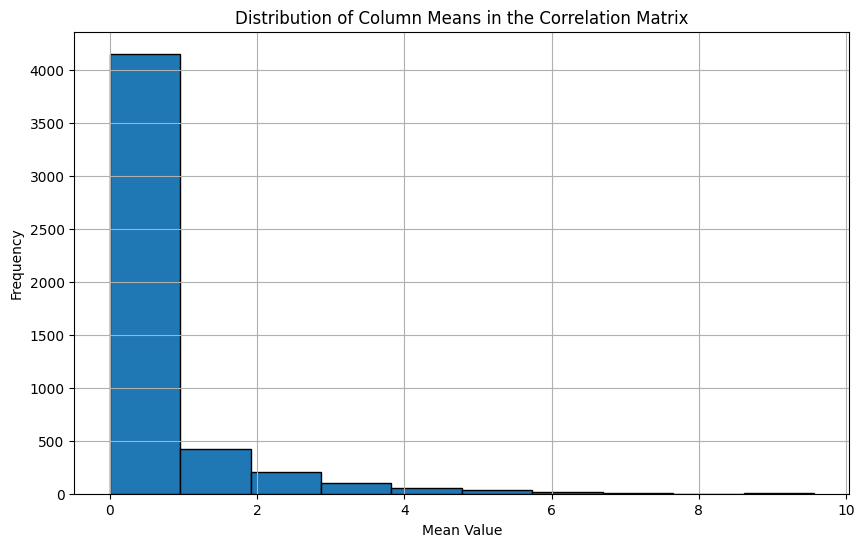

DF1 列变量与 DF2 列变量之间的相关性矩阵：


In [152]:
correlation_matrix = pd.concat([spatial_samples, metabolic_samples], axis=1)
print(correlation_matrix.shape)
column_means = correlation_matrix.mean(axis=0)
plt.figure(figsize=(10, 6))
plt.hist(column_means, bins=10, edgecolor='black')
plt.title('Distribution of Column Means in the Correlation Matrix')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
correlation_matrix = correlation_matrix.corr()
# 显示相关性矩阵
print("DF1 列变量与 DF2 列变量之间的相关性矩阵：")

# 显示 DF3
#print(DF3)

(2500, 2499)


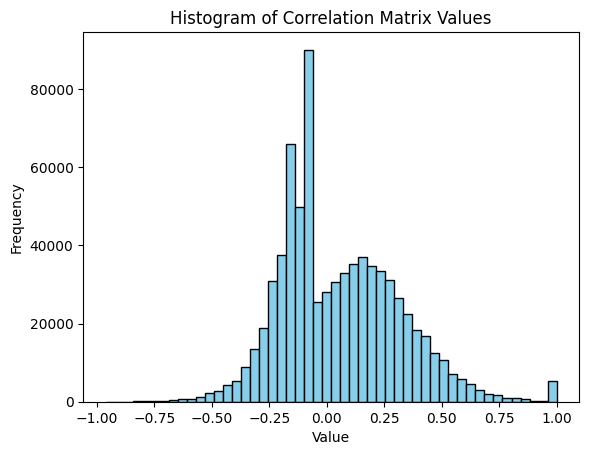

In [153]:
correlation_matrix2 = correlation_matrix.iloc[:2500, -2499:]
print(correlation_matrix2.shape)

values = correlation_matrix2.values.flatten()
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()
high_correlation_spatial = []
high_correlation_metabolic = []



In [154]:
import pandas as pd
import numpy as np

# Example correlation matrix with NaN values
correlation_matrix2[correlation_matrix2 > 0.95] = np.nan
# Flatten the correlation matrix and keep track of the row and column indices, excluding NaNs
flattened = correlation_matrix2.values.flatten()
non_nan_indices = ~np.isnan(flattened)
flattened_non_nan = flattened[non_nan_indices]
original_indices = np.dstack(np.unravel_index(np.where(non_nan_indices)[0], correlation_matrix2.shape))[0]

# Sort the non-NaN flattened array to find the top 20 highest values
sorted_indices = np.argsort(flattened_non_nan)[::-1]
top_n = 200
top_indices = original_indices[sorted_indices[:top_n]]

# Retrieve the corresponding row and column indices
top_rows = top_indices[:, 0]
top_cols = top_indices[:, 1]

# Get the top 20 highest values
top_values = flattened_non_nan[sorted_indices[:top_n]]

# Convert to lists if needed
top_rows = list(top_rows)
top_cols = list(top_cols)
top_values = list(top_values)

# Display results
print("Top 20 highest correlation values (excluding NaNs):")
for i in range(len(top_values)):
    print(f"Value: {top_values[i]}, Row: {top_rows[i]}, Column: {top_cols[i]}")

# Optionally, convert to a DataFrame for easier viewing
top_correlations_df = pd.DataFrame({
    'Value': top_values,
    'Row': top_rows,
    'Column': top_cols
})

print("\nTop 20 highest correlation values in DataFrame format:")
print(top_correlations_df)

unique_top_correlations_df = top_correlations_df.drop_duplicates(subset=['Column'])
unique_top_correlations_df = unique_top_correlations_df.drop_duplicates(subset=['Row'])
# 转换为列表（如果需要）
unique_top_rows = list(unique_top_correlations_df['Row'])
unique_top_cols = list(unique_top_correlations_df['Column'])
unique_top_values = list(unique_top_correlations_df['Value'])

print("\nTop correlation values in DataFrame format (unique pairs):")
print(unique_top_correlations_df)


Top 20 highest correlation values (excluding NaNs):
Value: 0.9494680858460344, Row: 746, Column: 514
Value: 0.9494680858460344, Row: 783, Column: 395
Value: 0.9494680858460344, Row: 746, Column: 395
Value: 0.9494680858460344, Row: 783, Column: 514
Value: 0.9493290855696638, Row: 268, Column: 1645
Value: 0.9491840052723342, Row: 695, Column: 748
Value: 0.9491840052723342, Row: 373, Column: 748
Value: 0.9459591477357898, Row: 870, Column: 2214
Value: 0.9446892286707963, Row: 2230, Column: 1413
Value: 0.9445809176009958, Row: 174, Column: 1740
Value: 0.9420212503524723, Row: 1540, Column: 262
Value: 0.9411761354802853, Row: 652, Column: 2080
Value: 0.9399671923245457, Row: 1403, Column: 1401
Value: 0.9396340592877842, Row: 1480, Column: 2379
Value: 0.9376049971187255, Row: 166, Column: 1413
Value: 0.9370872669279877, Row: 2375, Column: 2377
Value: 0.9370872669279877, Row: 1171, Column: 2377
Value: 0.9369123682424763, Row: 2437, Column: 149
Value: 0.9365695387379707, Row: 1354, Column: 137

In [155]:
import numpy as np
import matplotlib.pyplot as plt
scaler = MinMaxScaler(feature_range=(-1, 1))
metabolic_select_high_corr_variant = convert_to_array(adata1.X)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = scaler.fit_transform(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = metabolic_select_high_corr_variant.iloc[:,top_cols]
metabolic_select_high_corr_variant = pd.concat([data1_spatial_results, metabolic_select_high_corr_variant], axis=1)

spatial_select_high_corr_variant = convert_to_array(adata2.X)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = scaler.fit_transform(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = spatial_select_high_corr_variant.iloc[:,top_rows]
spatial_select_high_corr_variant = pd.concat([data2_spatial_results, spatial_select_high_corr_variant], axis=1)

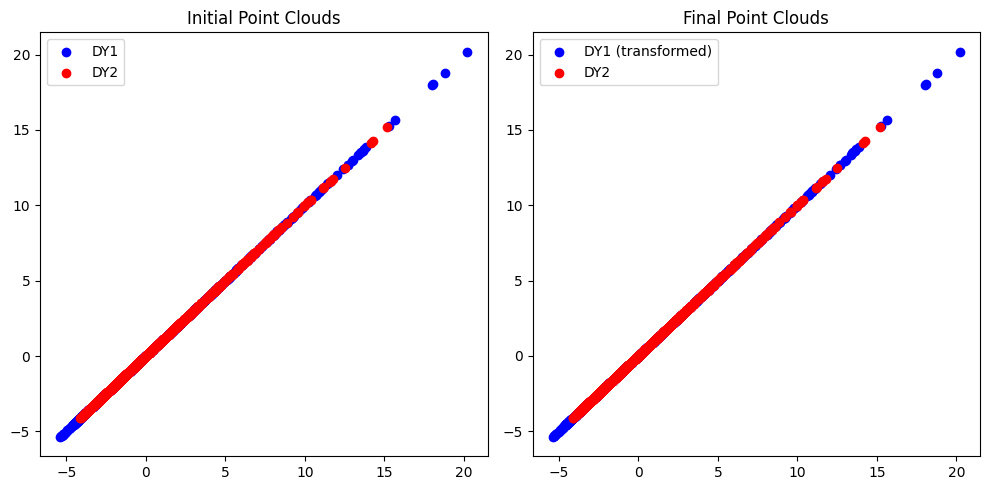

Final transformation matrix:
[[1.15463195e-17]
 [8.99280650e-18]
 [1.40998324e-17]]


In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

#DY1 = data2_spatial_results.T.values  # Example DY1 point cloud (2D points
#DY1 = data2_spatial_results.T.values
#DY2 = data3_spatial_results.T.values # Example DY2 point cloud (2D points)
DY1 = spatial_select_high_corr_variant.iloc[:,2:].T.to_numpy()  # Example DYGW1 features
DY2 = metabolic_select_high_corr_variant.iloc[:,2:].T.to_numpy()  # Example DYGW2 features
scaler1 = StandardScaler()
scaler2 = StandardScaler()
DY1 = scaler1.fit_transform(DY1.T).T
DY2 = scaler2.fit_transform(DY2.T).T

# Perform CCA
cca = CCA(n_components=1)
DY1_c, DY2_c = cca.fit_transform(DY1.T, DY2.T)
DY1 = DY1_c.T
DY2 = DY2_c.T
# 初始变换估计
transformation = np.eye(2)  # 初始变换矩阵为2x2的单位矩阵

# 设定迭代次数和收敛阈值
max_iterations = 500
tolerance = 1e-5

# 创建一个新的图形窗口
plt.figure(figsize=(10, 5))

# 绘制初始的DY1和DY2点云
plt.subplot(1, 2, 1)
plt.title('Initial Point Clouds')
plt.scatter(DY1[0], DY1[0], color='blue', label='DY1')
plt.scatter(DY2[0], DY2[0], color='red', label='DY2')
plt.legend()

iteration = 0
converged = False

while not converged and iteration < max_iterations:
    # Step 1: Find correspondences based on spatial proximity
    tree = cKDTree(DY2.T)
    distances, indices = tree.query(DY1.T)
    
    corresponding_target_points = DY2[:, indices]

    # Step 2: Optimize transformation using spatial and feature distances
    # Example: simple averaging transformation for illustration
    transformation = np.mean(corresponding_target_points - DY1, axis=1, keepdims=True)

    # Step 3: Apply transformation to DY1
    DY1_transformed = DY1 + transformation

    # Step 4: Update DY1 for the next iteration
    DY1 = DY1_transformed

    # Step 5: Check convergence
    if np.linalg.norm(transformation) < tolerance:
        converged = True

    iteration += 1

# 绘制最终的DY1和DY2点云
plt.subplot(1, 2, 2)
plt.title('Final Point Clouds')
plt.scatter(DY1[0], DY1[0], color='blue', label='DY1 (transformed)')
plt.scatter(DY2[0], DY2[0], color='red', label='DY2')
plt.legend()

plt.tight_layout()
plt.show()

print("Final transformation matrix:")
print(transformation)
DY1CCA = DY1
DY2CCA = DY2

ValueError: could not broadcast input array from shape (5,5) into shape (3,3)

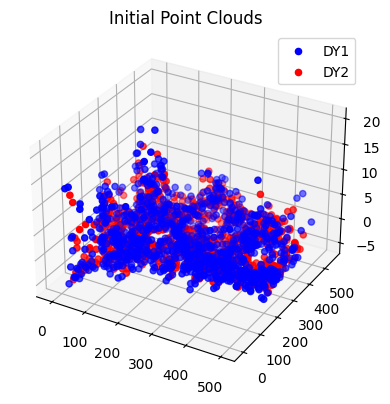

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
# Example 3D point cloud data (replace with your actual data)
DY1CCA = DY1
DY2CCA = DY2
DY1 = spatial_select_high_corr_variant.iloc[:,0:2].T.to_numpy()  # 3D point cloud DY1 (3 x N)
DY2 = metabolic_select_high_corr_variant.iloc[:,0:2].T.to_numpy()   # 3D point cloud DY2 (3 x M)
DY1 = np.vstack((DY1, DY1CCA))
DY2 = np.vstack((DY2, DY2CCA))

# 初始变换矩阵
transformation_matrix = np.eye(4)  # 初始变换矩阵为4x4单位矩阵

# 设置迭代参数
max_iterations = 500
tolerance = 1e-5

# 绘制初始点云
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(DY1[0], DY1[1], DY1[2], color='blue', label='DY1')
ax1.scatter(DY2[0], DY2[1], DY2[2], color='red', label='DY2')
ax1.set_title('Initial Point Clouds')
ax1.legend()

iteration = 0
converged = False

while not converged and iteration < max_iterations:
    # Step 1: Find correspondences based on spatial proximity
    tree = cKDTree(DY2.T)
    distances, indices = tree.query(DY1.T)

    corresponding_target_points = DY2[:, indices]

    # Step 2: Calculate centroids
    centroid_DY1 = np.mean(DY1, axis=1, keepdims=True)
    centroid_DY2 = np.mean(corresponding_target_points, axis=1, keepdims=True)

    # Step 3: Center the points
    DY1_centered = DY1 - centroid_DY1
    DY2_centered = corresponding_target_points - centroid_DY2

    # Step 4: Compute the covariance matrix
    H = DY1_centered @ DY2_centered.T

    # Step 5: Compute the Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Step 6: Ensure a proper rotation matrix (det(R) = 1)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    # Step 7: Compute the translation vector
    t = centroid_DY2 - R @ centroid_DY1

    # Step 8: Form the transformation matrix
    transformation = np.eye(4)
    transformation[:3, :3] = R
    transformation[:3, 3] = t.flatten()

    # Step 9: Apply the transformation
    DY1_homogeneous = np.vstack((DY1, np.ones((1, DY1.shape[1]))))
    DY1_transformed_homogeneous = transformation @ DY1_homogeneous
    DY1_transformed = DY1_transformed_homogeneous[:3, :]

    # Step 10: Update DY1|
    DY1 = DY1_transformed

    # Step 11: Check convergence
    if np.linalg.norm(transformation[:3, 3]) < tolerance:
        converged = True

    iteration += 1

# 绘制最终点云
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(DY1[0], DY1[1], DY1[2], color='blue', label='DY1 (transformed)')
ax2.scatter(DY2[0], DY2[1], DY2[2], color='red', label='DY2')
ax2.set_title('Final Point Clouds')
ax2.legend()

plt.tight_layout()
plt.show()

print("Final transformation matrix:")
print(transformation)

C:\Users\28123\AppData\Local\Temp\ipykernel_16672\2748365551.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1000, 3) (1000, 3)
(1000, 1000)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
   spatial.CCA.X  spatial.CCA.Y          2  spatial_ID  spatial_cluster  \
0      99.687143     198.017671  -3.623525           0                3   
1      97.933065     286.684984   4.776971           1                2   
2     404.078172     348.329988  -5.073390           2                6   
3      86.694029     297.790893  15.431002           3                9   
4      83.478736     430.970329  -2.933852           4                0   

   spatial.CCA.Z  metabolic.CCA.X  metabolic.CCA.Y          2  matabolic_ID  \
0             -1        99.351176       199.358632  -2.781053             0   
1             -1        98.337388       289.417424   4.017787             1   
2             -1       404.298459       348.743987  -3.948903             2   
3             -1        86.577453       298.236237  11.554862             3   
4             -1        81.305758       433.190807  -1.583429             4   

 

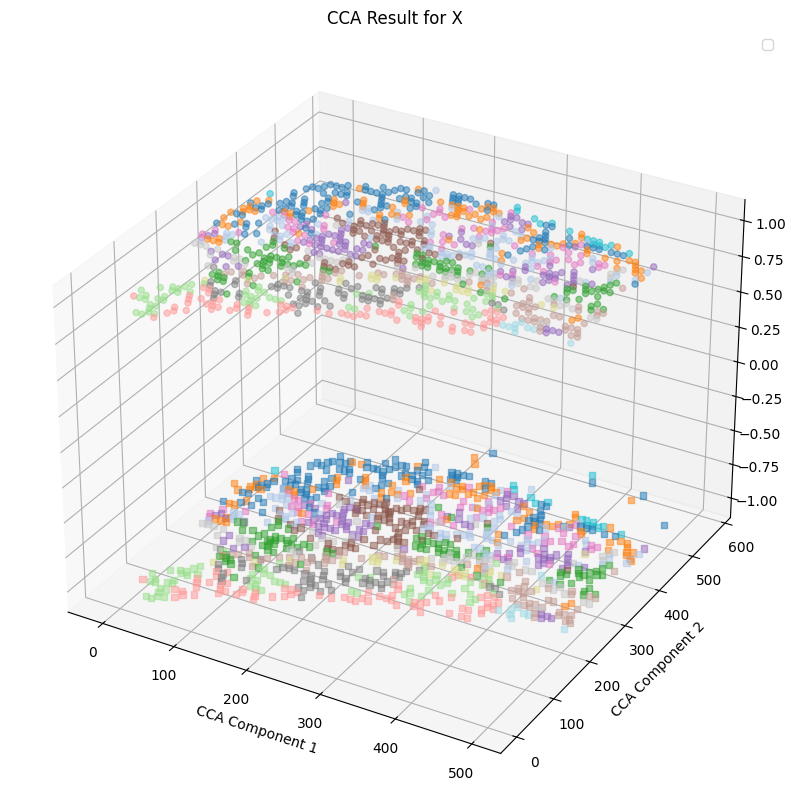

In [158]:
Y_c = pd.DataFrame(DY1).T
Z_c = pd.DataFrame(DY2).T
#Y_c = pd.DataFrame(G)
#Z_c = data3_spatial_results
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices_ = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices_,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices_].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

In [159]:
same_values_mask = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
Accruracy_haCCA = same_values_mask.sum()

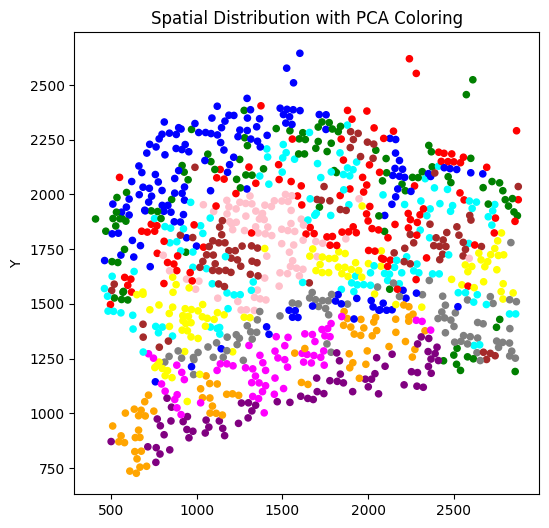

In [160]:
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
#plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\rat\\CCA_IPCalignment.pdf")
plt.show()


In [161]:
#pairs.to_csv("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\run2.csv", index=False)

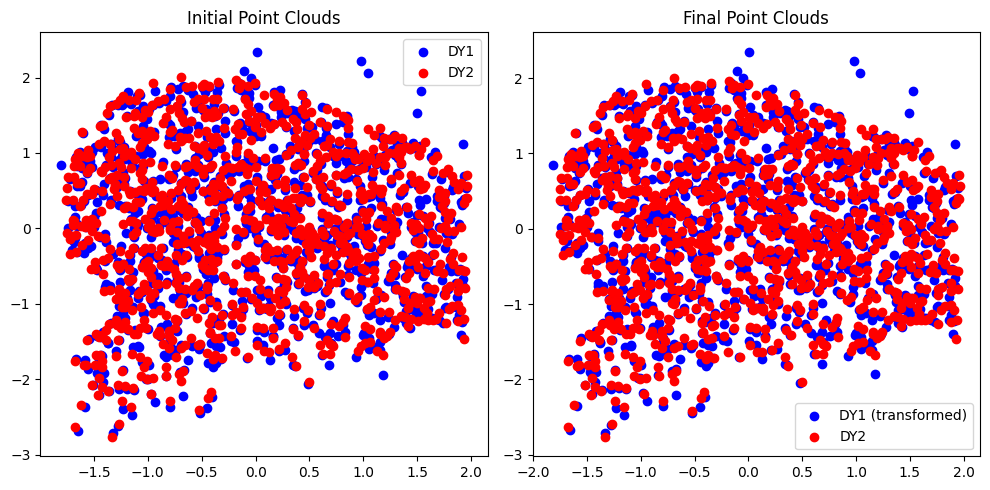

Final transformation matrix:
[[-2.42306175e-17]
 [-1.70280456e-17]]


In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

#DY1 = data2_spatial_results.T.values  # Example DY1 point cloud (2D points
#DY1 = data2_spatial_results.T.values
#DY2 = data3_spatial_results.T.values # Example DY2 point cloud (2D points)
DY1 = spatial_select_high_corr_variant.T.to_numpy()  # Example DYGW1 features
DY2 = metabolic_select_high_corr_variant.T.to_numpy()  # Example DYGW2 features
scaler1 = StandardScaler()
scaler2 = StandardScaler()
DY1 = scaler1.fit_transform(DY1.T).T
DY2 = scaler2.fit_transform(DY2.T).T

# Perform CCA
cca = CCA(n_components=2)
DY1_c, DY2_c = cca.fit_transform(DY1.T, DY2.T)
DY1 = DY1_c.T
DY2 = DY2_c.T
# 初始变换估计
transformation = np.eye(2)  # 初始变换矩阵为2x2的单位矩阵

# 设定迭代次数和收敛阈值
max_iterations = 500
tolerance = 1e-5

# 创建一个新的图形窗口
plt.figure(figsize=(10, 5))

# 绘制初始的DY1和DY2点云
plt.subplot(1, 2, 1)
plt.title('Initial Point Clouds')
plt.scatter(DY1[0], DY1[1], color='blue', label='DY1')
plt.scatter(DY2[0], DY2[1], color='red', label='DY2')
plt.legend()

iteration = 0
converged = False

while not converged and iteration < max_iterations:
    # Step 1: Find correspondences based on spatial proximity
    tree = cKDTree(DY2.T)
    distances, indices = tree.query(DY1.T)
    
    corresponding_target_points = DY2[:, indices]

    # Step 2: Optimize transformation using spatial and feature distances
    # Example: simple averaging transformation for illustration
    transformation = np.mean(corresponding_target_points - DY1, axis=1, keepdims=True)

    # Step 3: Apply transformation to DY1
    DY1_transformed = DY1 + transformation

    # Step 4: Update DY1 for the next iteration
    DY1 = DY1_transformed

    # Step 5: Check convergence
    if np.linalg.norm(transformation) < tolerance:
        converged = True

    iteration += 1

# 绘制最终的DY1和DY2点云
plt.subplot(1, 2, 2)
plt.title('Final Point Clouds')
plt.scatter(DY1[0], DY1[1], color='blue', label='DY1 (transformed)')
plt.scatter(DY2[0], DY2[1], color='red', label='DY2')
plt.legend()

plt.tight_layout()
plt.show()

print("Final transformation matrix:")
print(transformation)

In [170]:
DY1CCA

array([[-3.37741101,  4.97813167, -5.32035478, ..., -5.37767762,
         4.47325618, -3.58123601],
       [ 0.29968922, -2.49997809,  0.30359978, ...,  0.3339237 ,
        -2.18408835, -0.0054497 ],
       [-0.58651793,  3.25991591, -0.4762453 , ..., -0.56590864,
        -0.43522457,  0.96642526]])

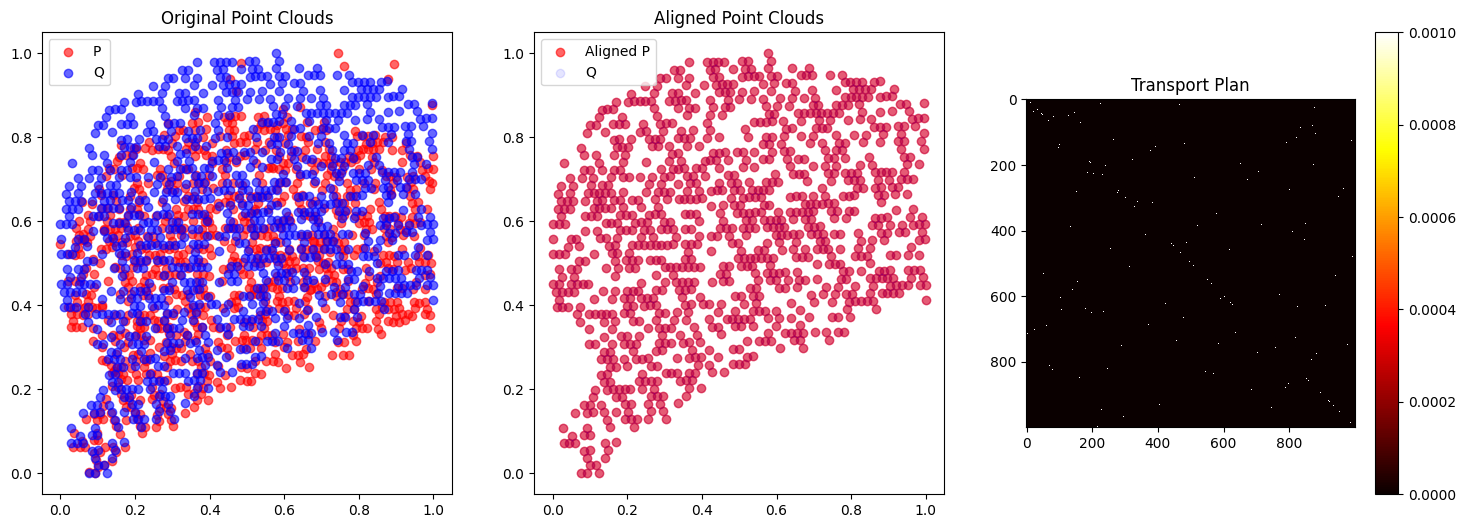

In [171]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# 假设 P 和 Q 是两个点云，形状分别为 (n, d) 和 (m, d)
P = data2_spatial_results.to_numpy()  # Example DYGW1 features
Q = data1_spatial_results.to_numpy()  # Example DYGW2 features

# 特征矩阵（这里假设特征与坐标相同）
F_P = DY1CCA
F_Q = DY2CCA

# 数据标准化
scaler = StandardScaler()
P = scaler.fit_transform(P)
Q = scaler.fit_transform(Q)

# 数据归一化
scaler = MinMaxScaler()
P = scaler.fit_transform(P)
Q = scaler.fit_transform(Q)

# 计算几何距离矩阵
C_P = np.linalg.norm(P[:, None, :] - P[None, :, :], axis=2)
C_Q = np.linalg.norm(Q[:, None, :] - Q[None, :, :], axis=2)

# 计算特征距离矩阵
M = np.linalg.norm(F_P[:, None, :] - F_Q[None, :, :], axis=2)

# 初始化权重，均匀分布
a = np.ones((P.shape[0],)) / P.shape[0]
b = np.ones((Q.shape[0],)) / Q.shape[0]

# 设置平衡参数
alpha = 0.5

# 设置参数
params = {
    'max_iter': 2000,    # 增加最大迭代次数
    'tol_rel': 1e-7,     # 调整相对容差
    'tol_abs': 1e-9,     # 调整绝对容差
    'armijo': True       # 使用Armijo线搜索
}

# 计算FGW最优传输计划
pi, log = ot.gromov.fused_gromov_wasserstein(M,C_P, C_Q, a, b, alpha=alpha, log=True, **params)

# 对齐点云 P 到 Q
P_aligned = np.dot(pi, Q)
scaler = StandardScaler()
P_aligned = scaler.fit_transform(P_aligned)
scaler = MinMaxScaler()
P_aligned = scaler.fit_transform(P_aligned)


# 可视化
plt.figure(figsize=(18, 6))

# 原始点云
plt.subplot(1, 3, 1)
plt.scatter(P[:, 0], P[:, 1], color='red', label='P', alpha=0.6)
plt.scatter(Q[:, 0], Q[:, 1], color='blue', label='Q', alpha=0.6)
plt.title('Original Point Clouds')
plt.legend()

# 对齐后的点云
plt.subplot(1, 3, 2)
plt.scatter(P_aligned[:, 0], P_aligned[:, 1], color='red', label='Aligned P', alpha=0.6)
plt.scatter(Q[:, 0], Q[:, 1], color='blue', label='Q', alpha=0.1)
plt.title('Aligned Point Clouds')
plt.legend()

# 可视化传输计划
plt.subplot(1, 3, 3)
plt.imshow(pi, cmap='hot', interpolation='nearest')
plt.title('Transport Plan')
plt.colorbar()

plt.show()


C:\Users\28123\AppData\Local\Temp\ipykernel_16672\2576077461.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1000, 2) (1000, 2)
(1000, 1000)
(1000, 2) (1000, 2)
(1000, 2) (1000, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0       0.229521       0.435061           0                3             -1   
1       0.807380       0.805986           1                2             -1   
2       0.808597       0.697488           2                6             -1   
3       0.187348       0.740780           3                9             -1   
4       0.360908       0.671833           4                0             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0         0.229521         0.435061           204                  3   
1         0.807380         0.805986           553                  9   
2         0.808597         0.697488             2                  6   
3         0.187348         0.740780           414                  0   
4         0.360908         0.671833           999                  7   

   matabolic.CCA.Z 

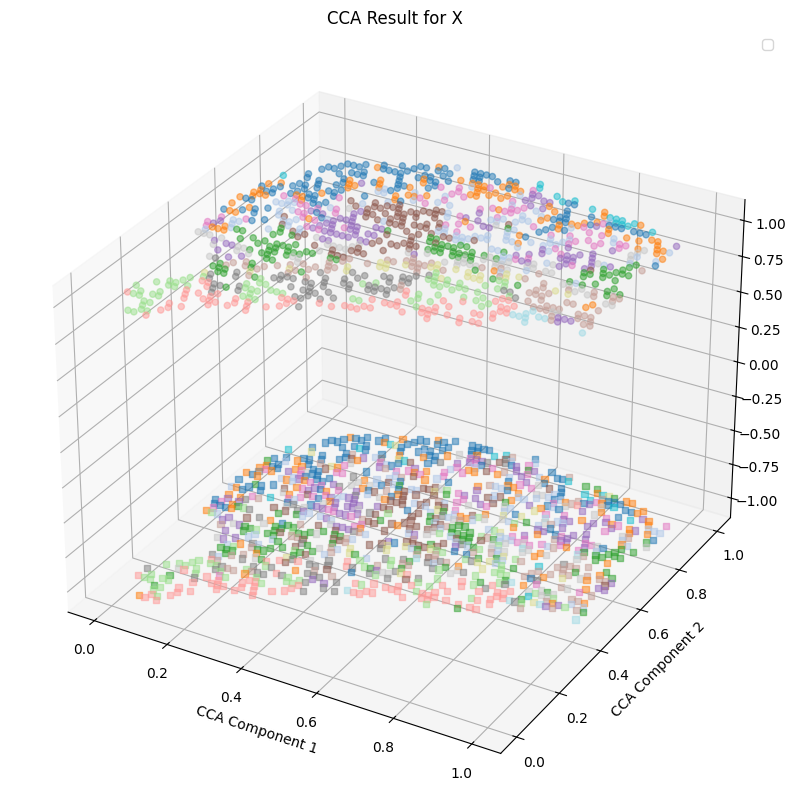

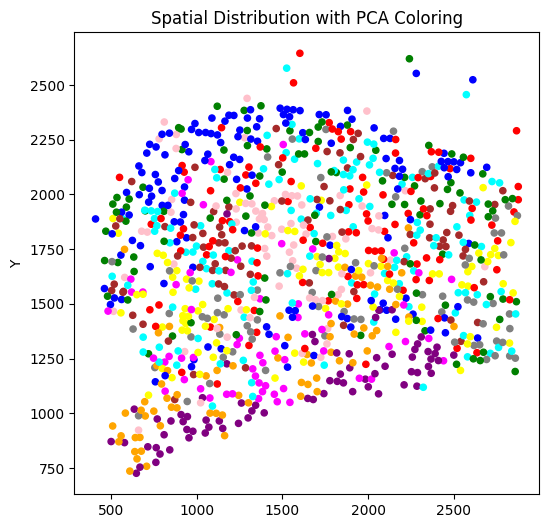

In [172]:
Y_c = pd.DataFrame(P_aligned)
Z_c = pd.DataFrame(Q)
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices_ = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices_,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices_].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str[:].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(pd.DataFrame(adata2.obsm['spatial']).iloc[:, 0],pd.DataFrame(adata2.obsm['spatial']).iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
#plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\benchmark\\rat\\FPWalignment.pdf")
plt.show()
same_values_mask_directmerge = pairs['spatial_cluster'] == pairs['matabolic_cluster']
# 计算相同值的个数
same_values_count_fine = same_values_mask_directmerge.sum()
accruracy_hacca_FPWmerge = same_values_count_fine

In [173]:
print(same_values_mask.sum())
print(same_values_count_fine)
print("SOTA: ",same_values_mask.sum()-same_values_count_fine )
print("directalignment: ",accruracy_directmerge)
print("grossalignment: ",Accruracy_grossalignment)
print("furtheralignment: ",Accruracy_furtheralignment)
print("ICP",accruracy_ICP)
print("FPW",accruracy_ICP)
print("haCCA: ",Accruracy_haCCA)
print("FPWhaCCA: ",accruracy_hacca_FPWmerge)

963
403
SOTA:  560
directalignment:  289
grossalignment:  962
furtheralignment:  474
ICP 462
FPW 462
haCCA:  963
FPWhaCCA:  403
